In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate_nn as srnn
import surrogate1 as sr1
import surrogate as sr
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
import hr_restrict as hrr
import time
from torch.autograd.functional import jacobian
from torchdiffeq import odeint as odeint
from scipy.fft import fft, fftfreq
from scipy.linalg import dft
import seaborn as sns
device = torch.device("cpu")

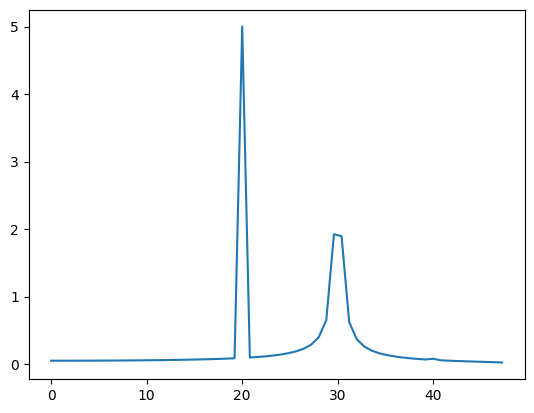

In [2]:
np.random.seed(28)
def get_func(n1, n2):
    n = np.random.randint(n2, size=n1)
    a_n = np.random.normal(size=n1)
    b_n = np.random.normal(size=n1)
    return lambda x: np.array([a_n[i]*np.cos(n_*x) + b_n[i]*np.sin(n_*x) for i, n_ in enumerate(n)]).sum(axis=0)

yr = get_func(3, 10)
x = np.linspace(-np.pi, np.pi, 1000)

pi2 = 2*np.pi
y = lambda x:  5*np.sin(pi2*20*x) + 3*np.sin(pi2*30*x) + 0.1*np.sin(pi2*50*x) + 0.05*np.sin(pi2*40*x)
# Number of sample points
N = 1000
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
yf = fft(y(x))
xf = fftfreq(N, T)[:60]
plt.plot(xf, 2.0/N * np.abs(yf[:60]))

Time taken by sample is 0.0067 seconds


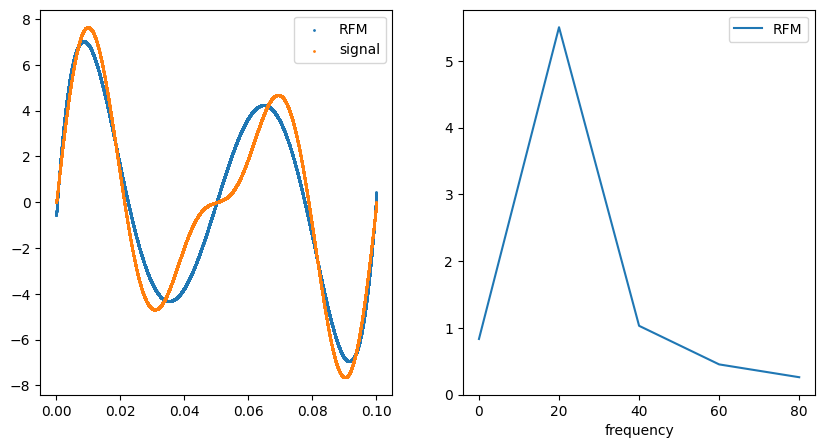

In [3]:
x = np.linspace(0., 0.1, int(1e6))
fx = y(x)
N = 20000
idx = np.sort(np.random.choice(len(x), size=N))
train_x = x[idx].reshape(1, -1)
train_y = fx[idx].reshape(1, -1)

sampler = hrr.GoodRowSampler(0.4, 3.5, train_x)
D_r=300
beta = 4e-9
# random feature map
Wb = sampler.sample(D_r)
W = np.random.uniform(-5., 5., size=(300, 1))
b = np.random.uniform(-2., 2., size=(300))
# rf = sr.SurrogateModel_LR(D=3, D_r=D_r, W_in_fn=Wb[:, :-1], b_in_fn=Wb[:, -1])
rf = sr.SurrogateModel_LR(D=3, D_r=D_r, W_in_fn=W, b_in_fn=b)
rf.compute_W_xy(train_x, train_y, beta)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

rf_y = rf.forecast_m(train_x).flatten()
ax1.scatter(train_x.flatten(), rf_y, s=1, label='RFM')
ax1.scatter(train_x.flatten(), train_y.flatten(), s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
rf_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
rf_y = rf.forecast_m(rf_x).flatten()
yf = fft(rf_y)#fft(y(rf_x.flatten()))
xf = fftfreq(N, T)[:N//10]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//10]), label='RFM')
ax2.set_xlabel('frequency')
ax2.legend()

In [4]:
network = srnn.SurrogateModel_NN(D=1, D_r=300, save_folder='../data/func-approx')
log_interval = 100
save_interval = 1000
update_frequency = 100
min_change = (1-0.01)**(1./log_interval) - 1.
network.learn_xy(train_x, train_y, beta=4e-9, learning_rate=1e-4, steps=10000, batch_size=100,\
                 max_delta=0.1, min_change=min_change, constant_rate=False, update_frequency=update_frequency, mode='simple-random')

step: 0 loss: 1522.902090 time: 0.0331 lr: 0.000100,  change: nan%
step: 100 loss: 1569.496636 time: 0.1088 lr: 0.000100,  change: 3.06%
--------------------------------------------------------------
             Attempting to decrease learning rate             
--------------------------------------------------------------
step: 200 loss: 1611.254871 time: 0.1801 lr: 0.000099,  change: 5.80%
--------------------------------------------------------------
             Attempting to decrease learning rate             
--------------------------------------------------------------
step: 300 loss: 1624.114470 time: 0.2508 lr: 0.000090,  change: 6.65%
--------------------------------------------------------------
             Attempting to decrease learning rate             
--------------------------------------------------------------
step: 400 loss: 1593.254384 time: 0.3210 lr: 0.000083,  change: 4.62%
--------------------------------------------------------------
             Attempting

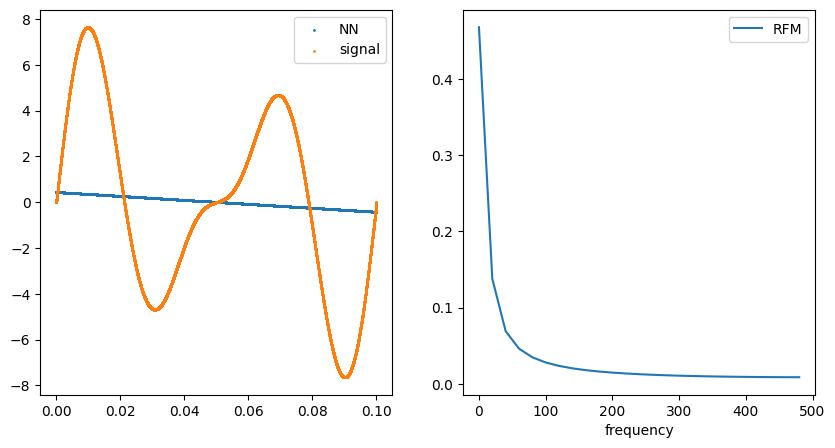

In [5]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

network_y = network.net(torch.from_numpy(train_x.T)).detach().numpy().flatten()
ax1.scatter(train_x.flatten(), network_y, s=1, label='NN')
ax1.scatter(train_x.flatten(), train_y, s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
network_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
network_y = network.net(torch.from_numpy(network_x.T)).detach().numpy().flatten()
yf = fft(network_y)#fft(y(network_x.flatten()))
xf = fftfreq(N, T)[:N//2]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='RFM')
ax2.set_xlabel('frequency')
ax2.legend()

In [ ]:
network = srnn.SurrogateModel_NN_multi(D=1, D_r=300, save_folder='../data/func-approx-multi')
log_interval = 100
save_interval = 1000
update_frequency = 100
min_change = (1-0.01)**(1./log_interval) - 1.
network.learn_xy(train_x, train_y, beta=0., learning_rate=1e-5, steps=10000, batch_size=1000,\
                 max_delta=0.1, min_change=min_change, constant_rate=True, update_frequency=update_frequency, mode='simple-random')

step: 0 loss: 15904.303048 time: 0.0410 lr: 0.000010,  change: nan%
step: 100 loss: 17448.482659 time: 1.4367 lr: 0.000010,  change: 9.71%
step: 200 loss: 16811.369990 time: 2.7998 lr: 0.000010,  change: 5.70%
step: 300 loss: 16153.156621 time: 4.1721 lr: 0.000010,  change: 1.56%
step: 400 loss: 16107.782693 time: 5.5389 lr: 0.000010,  change: 1.28%
step: 500 loss: 15030.749542 time: 6.9083 lr: 0.000010,  change: -5.49%
step: 600 loss: 14324.729748 time: 8.2827 lr: 0.000010,  change: -4.70%
step: 700 loss: 13416.310080 time: 9.6573 lr: 0.000010,  change: -6.34%
step: 800 loss: 13435.167955 time: 11.0488 lr: 0.000010,  change: 0.14%
step: 900 loss: 13209.161669 time: 12.4283 lr: 0.000010,  change: -1.54%
step: 1000 loss: 13206.421145 time: 13.8309 lr: 0.000010,  change: -0.02%
step: 1100 loss: 13693.984451 time: 15.2280 lr: 0.000010,  change: 3.69%
step: 1200 loss: 13144.156771 time: 16.6039 lr: 0.000010,  change: -0.47%
step: 1300 loss: 13133.067752 time: 17.9931 lr: 0.000010,  change:

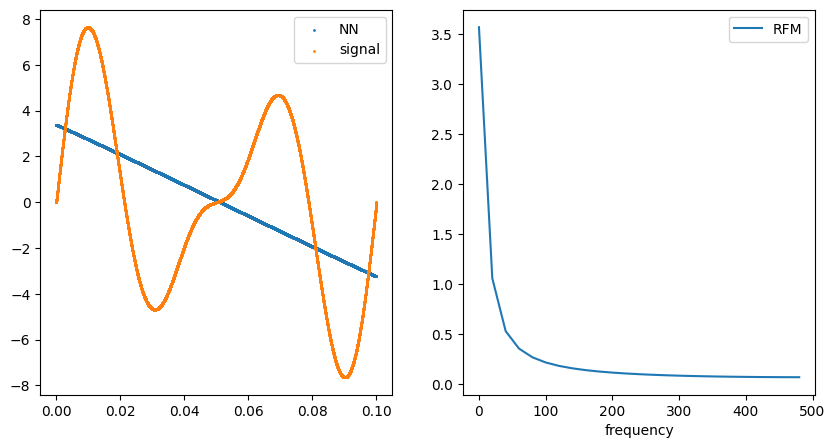

In [7]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

network_y = network.net(torch.from_numpy(train_x.T)).detach().numpy().flatten()
ax1.scatter(train_x.flatten(), network_y, s=1, label='NN')
ax1.scatter(train_x.flatten(), train_y, s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
network_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
network_y = network.net(torch.from_numpy(network_x.T)).detach().numpy().flatten()
yf = fft(network_y)#fft(y(network_x.flatten()))
xf = fftfreq(N, T)[:N//2]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='RFM')
ax2.set_xlabel('frequency')
ax2.legend()

In [6]:
network = srnn.SurrogateModel_NN_multi_bn(D=1, D_r=300, save_folder='../data/func-approx-multi-bn')
log_interval = 100
save_interval = 1000
update_frequency = 100
min_change = (1-0.01)**(1./log_interval) - 1.
network.learn_xy(train_x, train_y, beta=0., learning_rate=1e-5, steps=1000, batch_size=1000,\
                 max_delta=0.1, min_change=min_change, constant_rate=False, update_frequency=update_frequency, mode='simple-random')

step: 0 loss: 17795.714123 time: 0.0406 lr: 0.000010,  change: nan%
step: 100 loss: 4034.781294 time: 1.8191 lr: 0.000010,  change: -77.33%
step: 200 loss: 2086.437293 time: 3.5222 lr: 0.000010,  change: -48.29%
step: 300 loss: 942.274969 time: 5.2823 lr: 0.000010,  change: -54.84%
step: 400 loss: 610.617436 time: 7.0405 lr: 0.000010,  change: -35.20%
step: 500 loss: 335.114532 time: 8.8002 lr: 0.000010,  change: -45.12%
step: 600 loss: 377.367228 time: 10.5652 lr: 0.000010,  change: 12.61%
--------------------------------------------------------------
             Attempting to decrease learning rate             
--------------------------------------------------------------
step: 700 loss: 251.267492 time: 12.3268 lr: 0.000009,  change: -25.02%
step: 800 loss: 352.370850 time: 14.0914 lr: 0.000009,  change: 40.24%
--------------------------------------------------------------
             Attempting to decrease learning rate             
----------------------------------------------

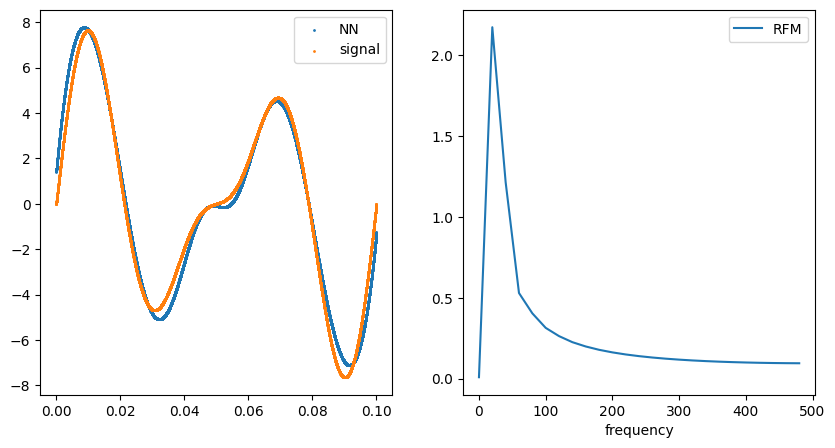

In [7]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

network_y = network.net(torch.from_numpy(train_x.T)).detach().numpy().flatten()
ax1.scatter(train_x.flatten(), network_y, s=1, label='NN')
ax1.scatter(train_x.flatten(), train_y, s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
network_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
network_y = network.net(torch.from_numpy(network_x.T)).detach().numpy().flatten()
yf = fft(network_y)#fft(y(network_x.flatten()))
xf = fftfreq(N, T)[:N//2]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='RFM')
ax2.set_xlabel('frequency')
ax2.legend()

In [7]:
network = srnn.SurrogateModel_NN_bn(D=1, D_r=300, save_folder='../data/func-approx-bn')
log_interval = 100
save_interval = 1000
update_frequency = 100
min_change = (1-0.01)**(1./log_interval) - 1.
network.learn_xy(train_x, train_y, beta=0., learning_rate=1e-5, steps=10000, batch_size=1000,\
                 max_delta=0.1, min_change=min_change, constant_rate=False, update_frequency=update_frequency, mode='simple-random')

step: 0 loss: 17282.243854 time: 0.0149 lr: 0.000010,  change: nan%
step: 100 loss: 16034.005293 time: 0.4984 lr: 0.000010,  change: -7.22%
step: 200 loss: 14669.025033 time: 0.9564 lr: 0.000010,  change: -8.51%
step: 300 loss: 14725.613675 time: 1.4161 lr: 0.000010,  change: 0.39%
--------------------------------------------------------------
             Attempting to decrease learning rate             
--------------------------------------------------------------
step: 400 loss: 13969.874479 time: 1.8756 lr: 0.000009,  change: -4.77%
step: 500 loss: 14173.656163 time: 2.3362 lr: 0.000009,  change: 1.46%
--------------------------------------------------------------
             Attempting to decrease learning rate             
--------------------------------------------------------------
step: 600 loss: 13440.975580 time: 2.8070 lr: 0.000009,  change: -3.79%
step: 700 loss: 13264.586656 time: 3.2667 lr: 0.000009,  change: -1.31%
step: 800 loss: 14298.322775 time: 3.7272 lr: 0.0000

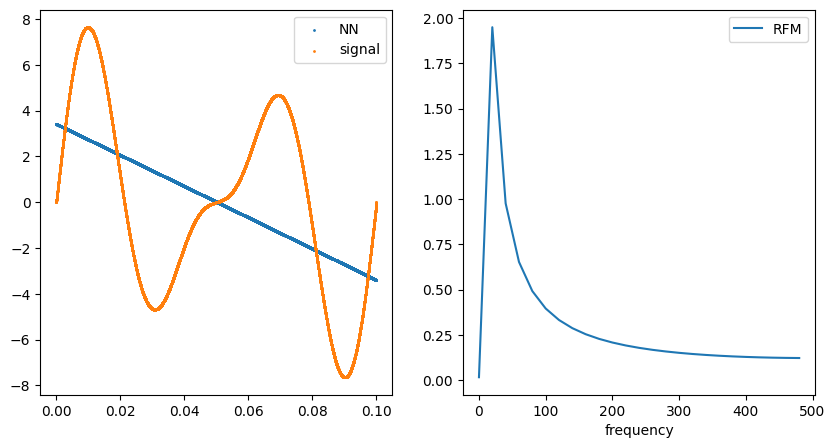

In [8]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

network_y = network.net(torch.from_numpy(train_x.T)).detach().numpy().flatten()
ax1.scatter(train_x.flatten(), network_y, s=1, label='NN')
ax1.scatter(train_x.flatten(), train_y, s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
network_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
network_y = network.net(torch.from_numpy(network_x.T)).detach().numpy().flatten()
yf = fft(network_y)#fft(y(network_x.flatten()))
xf = fftfreq(N, T)[:N//2]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='RFM')
ax2.set_xlabel('frequency')
ax2.legend()